<a href="https://colab.research.google.com/github/riavasdev/hello-world/blob/master/LR_chem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear regression to predict aqueous solubility

---
In this tutorial, we will learn to fit a linear regression model to the ESOL database in a bid to predict whether or not a given molecule is soluble in water.


In [1]:
#ria vasdev 05/12/25
!pip install rdkit
!pip install pandas
!pip install scikit-learn
!pip install numpy
!pip install matplotlib
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 19.3 MB/s eta 0:00:00


In [4]:
# import libraries in python
import numpy as np # constructing graphs and numerical data
import pandas as pd # reading and manipulating tabular data
import matplotlib.pyplot as plt # plotting graphs
import seaborn as sns # plotting graphs that look cooler (and are more descriptive)
from rdkit import Chem # generating molecular structures
from rdkit.Chem import Descriptors # generating molecular information and features

In [14]:
url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
df = pd.read_csv(url) #load dataset
print(df.head)


<bound method NDFrame.head of          Compound ID  ESOL predicted log solubility in mols per litre  \
0          Amigdalin                                           -0.974   
1           Fenfuram                                           -2.885   
2             citral                                           -2.579   
3             Picene                                           -6.618   
4          Thiophene                                           -2.232   
...              ...                                              ...   
1123       halothane                                           -2.608   
1124          Oxamyl                                           -0.908   
1125       Thiometon                                           -3.323   
1126  2-Methylbutane                                           -2.245   
1127        Stirofos                                           -4.320   

      Minimum Degree  Molecular Weight  Number of H-Bond Donors  \
0                  1      

In [15]:
#keeping only useful columns for analysis
df = df[["Compound ID","smiles", "ESOL predicted log solubility in mols per litre","measured log solubility in mols per litre"]]

In [23]:
from rdkit.Chem import Descriptors, rdMolDescriptors, PandasTools, Lipinski
PandasTools.AddMoleculeColumnToFrame(df, 'smiles', 'Molecule') #visualizing the molecule in the dataset

In [31]:
# Let's start with the usual suspects

def molecular_properties(df):

    df['Molecule'] = df['smiles'].apply(Chem.MolFromSmiles)

    df['MolWt'] = df['Molecule'].apply(Descriptors.MolWt) #molecular weight
    df['RotatableBonds'] = df['Molecule'].apply(Descriptors.NumRotatableBonds) #number of rotatable bonds
    df['LogP'] = df['Molecule'].apply(Descriptors.MolLogP) #octane-water partition coefficient
    df['HDonors'] = df['Molecule'].apply(Lipinski.NumHDonors) #number of hydrogen donors
    df['HAcceptors'] = df['Molecule'].apply(Lipinski.NumHAcceptors) #number f hydrogen acceptors
    df['TPSA'] = df['Molecule'].apply(rdMolDescriptors.CalcTPSA) #Topological Polar Surface Area

    return df


In [32]:
df = molecular_properties(df) #we now have a database with useful chemical properties

In [33]:
print(df[['MolWt', 'RotatableBonds', 'LogP', 'HDonors', 'HAcceptors', 'TPSA', 'measured log solubility in mols per litre']].head())

     MolWt  RotatableBonds     LogP  HDonors  HAcceptors    TPSA  \
0  457.432               7 -3.10802        7          12  202.32   
1  201.225               2  2.84032        1           2   42.24   
2  152.237               4  2.87800        0           1   17.07   
3  278.354               0  6.29940        0           0    0.00   
4   84.143               0  1.74810        0           1    0.00   

   measured log solubility in mols per litre  
0                                      -0.77  
1                                      -3.30  
2                                      -2.06  
3                                      -7.87  
4                                      -1.33  


Text(0.5, 1.02, 'Pairwise Scatterplots: Descriptors vs Solubility')

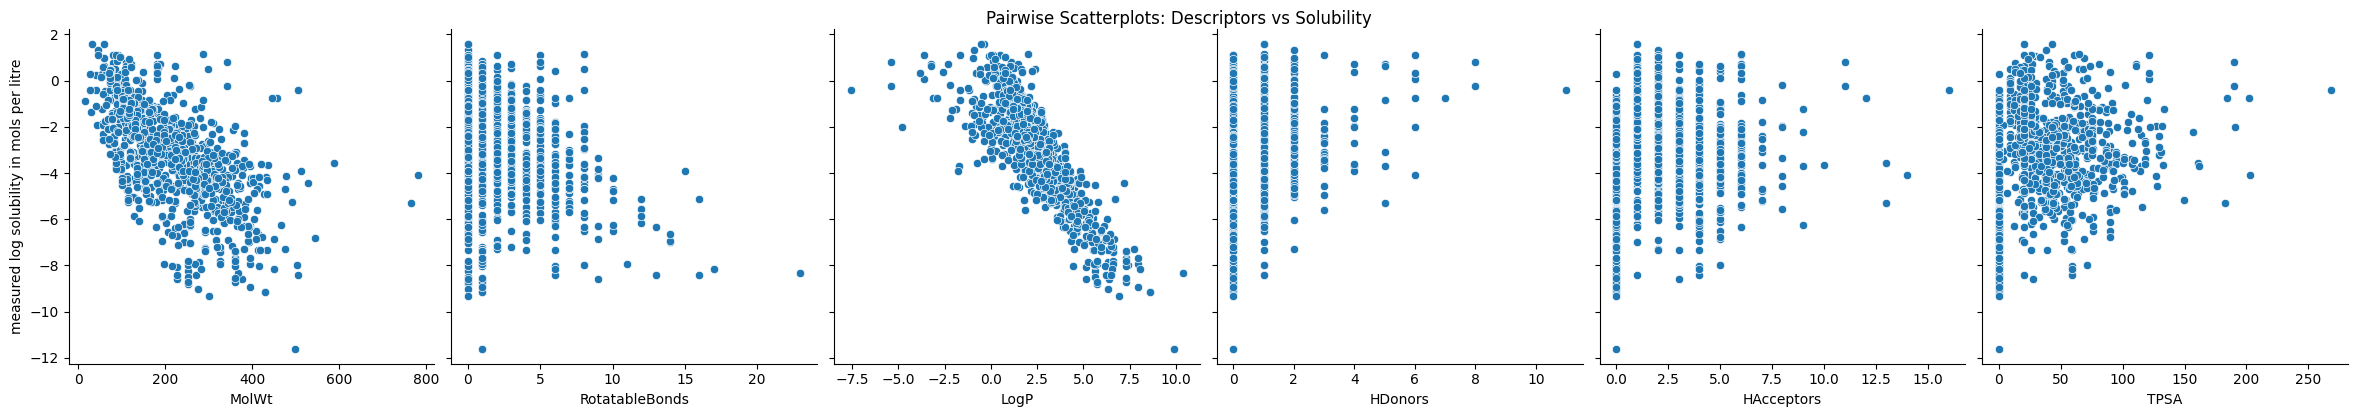

In [35]:
target = 'measured log solubility in mols per litre' # we are trying to predict solubility
features = ['MolWt', 'RotatableBonds', 'LogP', 'HDonors', 'HAcceptors', 'TPSA'] # with the assumption that these features are somehow important
sns.pairplot(df, x_vars=features, y_vars=[target], kind='scatter', height=4, aspect=1) # are there any meaningful trends?
plt.suptitle("Pairwise Scatterplots: Descriptors vs Solubility", y=1.02)

Text(0, 0.5, 'Solubility')

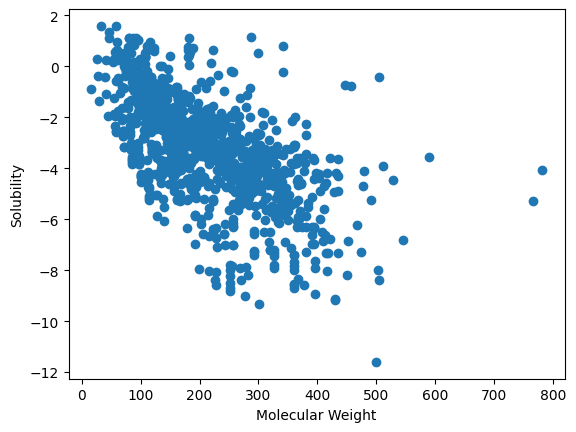

In [38]:
# let's fit a linear curve to one of these features to better understand its relation to solubility

#molecular weight
mol_wt = df['MolWt']
solubility = df['measured log solubility in mols per litre']
plt.scatter(mol_wt,solubility)
plt.xlabel("Molecular Weight")
plt.ylabel("Solubility")

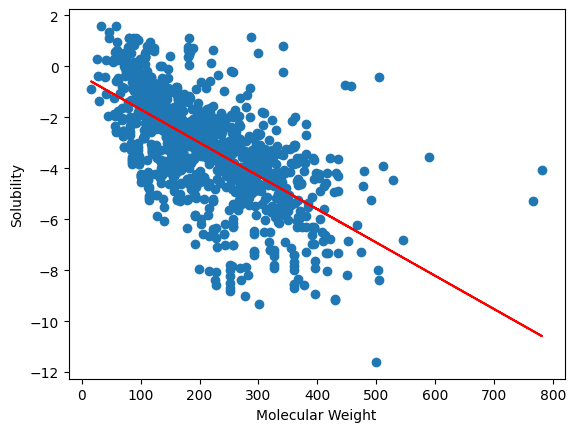

In [40]:
# y = mx + b
m, b = np.polyfit(mol_wt, solubility, 1)
plt.scatter(mol_wt, solubility)
plt.xlabel("Molecular Weight")
plt.ylabel("Solubility")
plt.plot(mol_wt, m*mol_wt + b, color='red')


# What can we infer here?

---

While the solubility and molecular weight correlation seems to be roughly linear for molecular weights upto ~500. The linear curve fails to accurately predict these values at higher mol weights. There are also large deviations in our predicted and true values throughout the data.

(-10.0, 3.0)

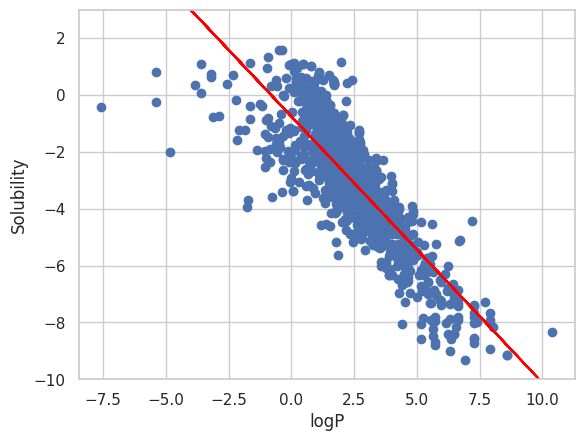

In [64]:
# what about logP?
logP = df['LogP']
m, b = np.polyfit(logP, solubility, 1)
plt.scatter(logP, solubility)
plt.xlabel("logP")
plt.ylabel("Solubility")
plt.plot(logP, m*logP + b, color='red')
plt.ylim(-10,3)

# Much better!

--

LogP seems to be a better indicator of solubility but we can build a more robust model if we take into consideration all of our input features.

In [69]:
# doing linear regression with all of our input variables
import sklearn.metrics
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
k = 3
repeats = 10
model = LinearRegression()
cv = RepeatedKFold(n_splits=k, n_repeats=repeats, random_state=1) #optional cross validating
scores = cross_validate(model, X_train, y_train, cv=cv,
                        scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'))
model.fit(X_train, y_train)
Y_pred_test = model.predict(X_test)


Text(0.5, 1.0, 'parity plot of solubility')

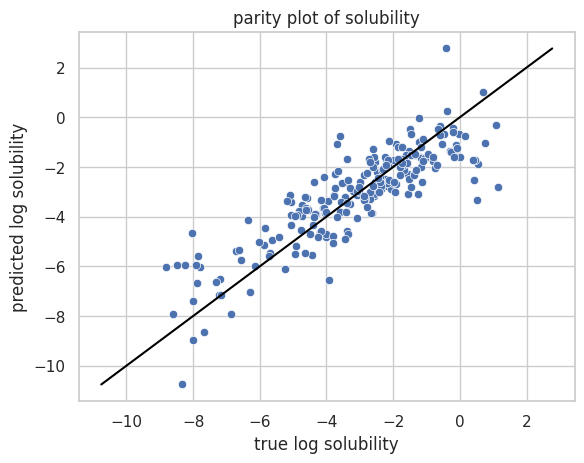

In [63]:
sns.scatterplot(x=y_test, y=Y_pred_test)
lims = [min(y_test.min(), Y_pred_test.min()), max(y_test.max(), Y_pred_test.max())] #set limits for plot
plt.plot(lims, lims, 'black')
plt.xlabel("true log solubility")
plt.ylabel("predicted log solubility")
plt.title("parity plot of solubility")

In [67]:
from math import ceil
mse = -np.mean(scores["test_neg_mean_squared_error"])
mae = -np.mean(scores["test_neg_mean_absolute_error"])
r2 = np.mean(scores["test_r2"])
# standard errors of metrics
mse_se = np.std(scores["test_neg_mean_squared_error"], ddof=1)/np.sqrt(k*repeats)
mae_se = np.std(scores["test_neg_mean_absolute_error"], ddof=1)/np.sqrt(k*repeats)
r2_se = np.std(scores["test_r2"], ddof=1)/np.sqrt(k*repeats)

print(f'Mean squared error (MSE): {mse:.3f} ± {ceil(mse_se*1000)/1000:.3f}')
print(f'Mean absolute error (MAE): {mae:.3f} ± {ceil(mae_se*1000)/1000:.3f}')
print(f'Coefficient of determination (R^2): {r2:.3f} ± {ceil(r2_se*1000)/1000:.3f}')

Mean squared error (MSE): 0.949 ± 0.012
Mean absolute error (MAE): 0.768 ± 0.005
Coefficient of determination (R^2): 0.778 ± 0.004
